## Importing Libraries



In [1]:
import numpy as np
import pandas as pd
import pickle

np.random.seed(42)

## GBOOST TREE NODES    
---

> This class defines a node which creates a tree structure by recursively calling itself whilst checking a number of ending parameters such as depth and min_leaf.
It uses an exact greedy method to exhaustively scan every possible split point.
Algorithm is based on Frieman's 2001 Gradient Boosting Machines.


<br>

### Class Functions:
---

**find_varsplit:**

        Scans through every column and calcuates the best split point.
        The node is then split at this point and two new nodes are created.
        Depth is only parameter to change as we have added a new layer to tree structure.
        If no split is better than the score initalised at the beginning then no splits further splits are made.

---
**find_greedy_split:**


        For a given feature calculates the gain at each split.
        Globally updates the best score if a better split point is found.

---
**gain:**

        Computes the gain for a specific split point based on Frieman's 2001 Gradient Boosting Machines

---
**compute_gamma:**

        This is the optimal leaf node value from Frieman's 2001 Gradient Boosting Machines for a GBM classifier.

---
### Inputs:



> X: Pandas dataframe <br>
  y: Pandas Series <br>
  idxs: indices of values used to keep track of splits points in tree <br>
  min_leaf: minimum number of samples needed to be classified as a node <br>
  depth: sets the maximum depth allowed.

---
### Output:

> Regression tree that can be used in gradient booting for regression.

In [2]:
class Node:
    def __init__(self, x, y, idxs, min_leaf=5, depth = 10):

        self.x, self.y = x, y
        self.idxs = idxs
        self.depth = depth
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = self.compute_gamma(y[self.idxs])
        self.score = float('-inf')
        self.find_varsplit()

    def find_varsplit(self):
        for c in range(self.col_count): self.find_greedy_split(c)
        if self.is_leaf: return
        x = self.split_col

        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf, depth = self.depth-1)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf, depth = self.depth-1)

    def find_greedy_split(self, var_idx):

        x = self.x.values[self.idxs, var_idx]

        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]

            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf):continue
            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score:
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]


    def gain(self, lhs, rhs):

        gradient = self.y[self.idxs]

        lhs_gradient = gradient[lhs].sum()
        lhs_n_intances = len(gradient[lhs])
        rhs_gradient = gradient[rhs].sum()
        rhs_n_intances = len(gradient[rhs])

        gain = ((lhs_gradient**2/(lhs_n_intances)) + (rhs_gradient**2/(rhs_n_intances))
                - ((lhs_gradient + rhs_gradient)**2/(lhs_n_intances + rhs_n_intances)))
        return(gain)

    @staticmethod
    def compute_gamma(gradient):
        return(np.sum(gradient)/len(gradient))

    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('-inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

## DECISION TREE REGRESSOR
---

> This class is a Wrapper class that provides a scikit learn interface to the recursive regression tree above. It provides methods to fit and predict datapoints for a single decision tree.

### Inputs:



> X: Pandas dataframe <br>
      y: Pandas Series <br>
      min_leaf: minimum number of samples needed to be classified as a node <br>
      depth: sets the maximum depth allowed

---
### Output:

>  A regression tree which has all weights learnt.

In [3]:
class DecisionTreeRegressor:

    def fit(self, X, y, min_leaf = 5, depth = 5):
        self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf, depth)
        return self

    def predict(self, X):
        return self.dtree.predict(X.values)

## GRADIENT BOOSTING REGRESSOR
---

> This class applies the methodology of gradeint boosting machines Friedman 2001 for regression. It uses the mean squared loss function to calculate the negative derivate.

### Inputs:



> X: Pandas dataframe <br>
      y: Pandas Series <br>
      min_leaf: minimum number of samples needed to be classified as a node <br>
      depth: sets the maximum depth allowed <br>
      Boosting_Rounds: number of boosting rounds or iterations

---
### Output:

>  Gradient boosting machine that can be used for regression.

In [11]:
class GradientBoostingRegressor:
    def __init__(self, classification = False):
        self.estimators = []

    @staticmethod
    def MeanSquaredError(y, y_pred):
        return(np.mean((y - y_pred)**2))

    @staticmethod
    def negativeMeanSquaredErrorDerivitive(y, y_pred):
        return(2*(y-y_pred))

    def SimulatedAnnealing(self,Y,gradients,pred,num_iter,initial_learning_rate):
        current_learning_rate = initial_learning_rate
        cur_energy = self.MeanSquaredError(Y,pred+current_learning_rate*gradients)
        Temp = np.sum((Y-pred)**2)
        Alpha = 0.85
        for i in range(num_iter):
            new_learning_rate = np.random.uniform(current_learning_rate - current_learning_rate/100, current_learning_rate + current_learning_rate/100)
            rand_energy =  self.MeanSquaredError(Y,pred+new_learning_rate*gradients)

            delta_energy = rand_energy-cur_energy
            delta_energy = delta_energy/Temp

            try:
                if np.exp(-delta_energy) >= np.random.uniform(0,1):
                    current_learning_rate = new_learning_rate
                    cur_energy = rand_energy
            except OverflowError:
                break

            Temp = Temp * (Alpha)
        return current_learning_rate

    def fit(self, X, y, depth = 5, min_leaf = 5, learning_rate = 0.1, boosting_rounds = 5, method = "fixed", initial_temperature = 5, cooling_rate = 1, beta1 = 0.8, beta2 = 0.999, epsilon = 1e-8):

        # Start with the mean y value as our initial prediciton
        self.learning_rate = learning_rate
        self.base_pred = np.full((X.shape[0], 1), np.mean(y)).flatten()

        if (method=="fixed"):
          for booster in range(boosting_rounds):
            # Calculate the initial Pseudo Residuals using Base Prediction.
              pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
              boosting_tree = DecisionTreeRegressor().fit(X = X, y = pseudo_residuals, depth = 5, min_leaf = 5)
              self.base_pred += self.learning_rate * boosting_tree.predict(X)
              self.estimators.append(boosting_tree)
              print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
              print("TRAINING LOSS: ",self.MeanSquaredError(y,self.base_pred),end = "\t")
              print("TESTING LOSS: ",self.MeanSquaredError(test_df['PJME_MW'] , self.predict(test_df.drop(columns = ['PJME_MW']))  ))

        elif (method=="simulated_annealing"):
          for booster in range(boosting_rounds):

              # Calculate the initial Pseudo Residuals using Base Prediction.
              pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
              boosting_tree = DecisionTreeRegressor().fit(X = X, y = pseudo_residuals, depth = 5, min_leaf = 5)
              #Finding best learning rate for new predictions
              self.learning_rate = self.SimulatedAnnealing(y,boosting_tree.predict(X),self.base_pred,100,self.learning_rate)
              self.base_pred += self.learning_rate * boosting_tree.predict(X)
              self.estimators.append(boosting_tree)
              print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
              print("TRAINING LOSS: ",self.MeanSquaredError(y,self.base_pred),end = "\t")
              print("TESTING LOSS: ",self.MeanSquaredError(test_df['PJME_MW'] , self.predict(test_df.drop(columns = ['PJME_MW']))  ))

        elif (method=="adam"):
          m = np.zeros(shape=self.base_pred.shape)
          v = np.zeros(shape=self.base_pred.shape)
          for booster in range(boosting_rounds):
              pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
              boosting_tree = DecisionTreeRegressor().fit(X = X, y = pseudo_residuals, depth = 5, min_leaf = 5)

              gradients = boosting_tree.predict(X)
              m = beta1*m + (1-beta1)*gradients
              v = beta2*v + (1-beta2)*(gradients**2)
              m_hat = m / (1 - beta1**(booster+1))
              v_hat = v / (1 - beta2**(booster+1))
              new_gradients = m_hat / (np.sqrt(v_hat) + epsilon)

              self.base_pred += self.learning_rate * new_gradients
              self.estimators.append(boosting_tree)
              print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
              print("TRAINING LOSS: ",self.MeanSquaredError(y,self.base_pred),end = "\t")
              print("TESTING LOSS: ",self.MeanSquaredError(test_df['PJME_MW'] , self.predict(test_df.drop(columns = ['PJME_MW']))  ))

        elif (method=="custom"):
          for booster in range(boosting_rounds):
              pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
              boosting_tree = DecisionTreeRegressor().fit(X = X, y = pseudo_residuals, depth = 5, min_leaf = 5)
              self.base_pred += (self.learning_rate*(boosting_rounds/(booster+1))**0.3) * boosting_tree.predict(X)
              self.estimators.append(boosting_tree)
              print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
              print("TRAINING LOSS: ",self.MeanSquaredError(y,self.base_pred),end = "\t")
              print("TESTING LOSS: ",self.MeanSquaredError(test_df['PJME_MW'] , self.predict(test_df.drop(columns = ['PJME_MW']))  ))


    def predict(self, X):

        pred = np.zeros(X.shape[0])
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X)

        return np.full((X.shape[0], 1), np.mean(y)).flatten() + pred

## Loading the dataframe

In [5]:
with open('dataframe.pickle', 'rb') as f:
    df = pickle.load(f)

df.head()

,Datetime,PJME_MW,Lag1,Lag2,Hour_sin,Hour_cos,Day_sin,Day_cos
0,2004-12-31 01:00:00,27160.0,27077.0,25591.0,0.258819,0.965926,-2.449294e-16,1.0
1,2004-12-31 02:00:00,25791.0,25957.0,24235.0,0.500000,0.866025,-2.449294e-16,1.0
2,2004-12-31 03:00:00,25052.0,24930.0,23121.0,0.707107,0.707107,-2.449294e-16,1.0
3,2004-12-31 04:00:00,24797.0,24359.0,22445.0,0.866025,0.500000,-2.449294e-16,1.0
4,2004-12-31 05:00:00,25026.0,24400.0,22332.0,0.965926,0.258819,-2.449294e-16,1.0


### Preprocessing

In [6]:
num_rows = df.shape[0]
df=df[:3000]

# 80-20 split
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

train_df=train_df.drop(columns=['Datetime'])
test_df=test_df.drop(columns=['Datetime'])

In [7]:
print("Training dataframe shape: ",train_df.shape)
print("Testing dataframe shape: ",test_df.shape)

Training dataframe shape:  (2400, 7)
Testing dataframe shape:  (600, 7)


In [8]:
train_df.head()

,PJME_MW,Lag1,Lag2,Hour_sin,Hour_cos,Day_sin,Day_cos
1801,21358.0,21587.0,22789.0,9.659258e-01,0.258819,-0.960150,0.279486
1190,34078.0,32086.0,31914.0,-7.071068e-01,-0.707107,-0.745438,0.666575
1817,30135.0,28557.0,30868.0,-7.071068e-01,0.707107,-0.960150,0.279486
251,39269.0,34730.0,28845.0,1.224647e-16,-1.000000,-0.170830,0.985301
2505,31896.0,33720.0,36906.0,-2.588190e-01,-0.965926,-0.977064,-0.212947


## Training

In [9]:
# Initialize the model
model = GradientBoostingRegressor()
train_df=train_df.reset_index(drop=True)

# Fit the model
X=train_df.drop(columns = ['PJME_MW'])
y=train_df['PJME_MW']

model.fit(X,y , depth=5, min_leaf=5, learning_rate=0.1, boosting_rounds=5, method = "fixed")

Boosting round 1 / 5 completed.
TRAINING LOSS:  19716915.52855378	TESTING LOSS:  19822653.677968577
Boosting round 2 / 5 completed.
TRAINING LOSS:  14626615.67027518	TESTING LOSS:  14940828.643009365
Boosting round 3 / 5 completed.
TRAINING LOSS:  11237239.384072155	TESTING LOSS:  11818192.305026405
Boosting round 4 / 5 completed.
TRAINING LOSS:  8965998.097007204	TESTING LOSS:  9645456.002655512
Boosting round 5 / 5 completed.
TRAINING LOSS:  7337775.4196892455	TESTING LOSS:  8232377.206004226


In [13]:
# Initialize the model
model = GradientBoostingRegressor()
train_df=train_df.reset_index(drop=True)

# Fit the model
X=train_df.drop(columns = ['PJME_MW'])
y=train_df['PJME_MW']

model.fit(X,y , depth=5, min_leaf=5, learning_rate=0.1, boosting_rounds=5, method = "simulated_annealing")

Boosting round 1 / 5 completed.
TRAINING LOSS:  19249877.324469816	TESTING LOSS:  19371660.337495133
Boosting round 2 / 5 completed.
TRAINING LOSS:  13665364.013540307	TESTING LOSS:  13614990.828878582
Boosting round 3 / 5 completed.
TRAINING LOSS:  10279824.059405435	TESTING LOSS:  10892273.455277417
Boosting round 4 / 5 completed.
TRAINING LOSS:  8050009.93194894	TESTING LOSS:  8499945.556809718
Boosting round 5 / 5 completed.
TRAINING LOSS:  6297964.510852389	TESTING LOSS:  6239913.47325186


In [14]:
# Initialize the model
model = GradientBoostingRegressor()
train_df=train_df.reset_index(drop=True)

# Fit the model
X=train_df.drop(columns = ['PJME_MW'])
y=train_df['PJME_MW']

model.fit(X,y , depth=5, min_leaf=5, learning_rate=0.1, boosting_rounds=5, method = "adam")

Boosting round 1 / 5 completed.
TRAINING LOSS:  27391667.537451673	TESTING LOSS:  19822653.677968577
Boosting round 2 / 5 completed.
TRAINING LOSS:  27390950.841701195	TESTING LOSS:  14109506.756391458
Boosting round 3 / 5 completed.
TRAINING LOSS:  27390234.167781975	TESTING LOSS:  10154042.211654052
Boosting round 4 / 5 completed.
TRAINING LOSS:  27389517.516401187	TESTING LOSS:  7956173.28793512
Boosting round 5 / 5 completed.
TRAINING LOSS:  27388800.888241794	TESTING LOSS:  7515813.232175195


In [15]:
# Initialize the model
model = GradientBoostingRegressor()
train_df=train_df.reset_index(drop=True)

# Fit the model
X=train_df.drop(columns = ['PJME_MW'])
y=train_df['PJME_MW']

model.fit(X,y , depth=5, min_leaf=5, learning_rate=0.1, boosting_rounds=5, method = "custom")

Boosting round 1 / 5 completed.
TRAINING LOSS:  15810922.230863314	TESTING LOSS:  19822653.677968577
Boosting round 2 / 5 completed.
TRAINING LOSS:  11040472.475926762	TESTING LOSS:  15535024.676799022
Boosting round 3 / 5 completed.
TRAINING LOSS:  8451795.804200886	TESTING LOSS:  12787848.870607832
Boosting round 4 / 5 completed.
TRAINING LOSS:  6925761.075294215	TESTING LOSS:  10979702.479904467
Boosting round 5 / 5 completed.
TRAINING LOSS:  5943870.97934213	TESTING LOSS:  9717776.448533287


# Making Predictions

In [16]:
predictions = model.predict(test_df.drop(columns = ['PJME_MW']))

In [17]:
Actual_Values = np.array(test_df['PJME_MW'])
Predicted_Values = predictions
pd.DataFrame({'Actual Values':Actual_Values, 'Predicted Values':Predicted_Values})

,Actual Values,Predicted Values
0,25791.0,29495.922198
1,25026.0,27505.592331
2,31225.0,31271.062956
3,30679.0,31373.334262
4,33004.0,33652.642043
...,...,...
595,31027.0,33650.795642
596,28260.0,30317.529752
597,27557.0,29117.840008
598,28573.0,34147.465697


In [18]:
print('MSE: '+str(model.MeanSquaredError(Actual_Values,Predicted_Values)))
print('RMSE: '+str(model.MeanSquaredError(Actual_Values,Predicted_Values)**0.5))

MSE: 9717776.448533287
RMSE: 3117.3348309947855


In [19]:
predictions = model.predict(df.drop(columns = ['PJME_MW','Datetime']))
Actual_Values = np.array(df['PJME_MW'])
Predicted_Values = predictions
pd.DataFrame({'Actual Values':Actual_Values, 'Predicted Values':Predicted_Values})

,Actual Values,Predicted Values
0,27160.0,29325.063186
1,25791.0,29495.922198
2,25052.0,27505.592331
3,24797.0,27505.592331
4,25026.0,27505.592331
...,...,...
2995,39472.0,35052.990500
2996,36218.0,34288.935254
2997,31957.0,33258.977846
2998,29949.0,29117.840008


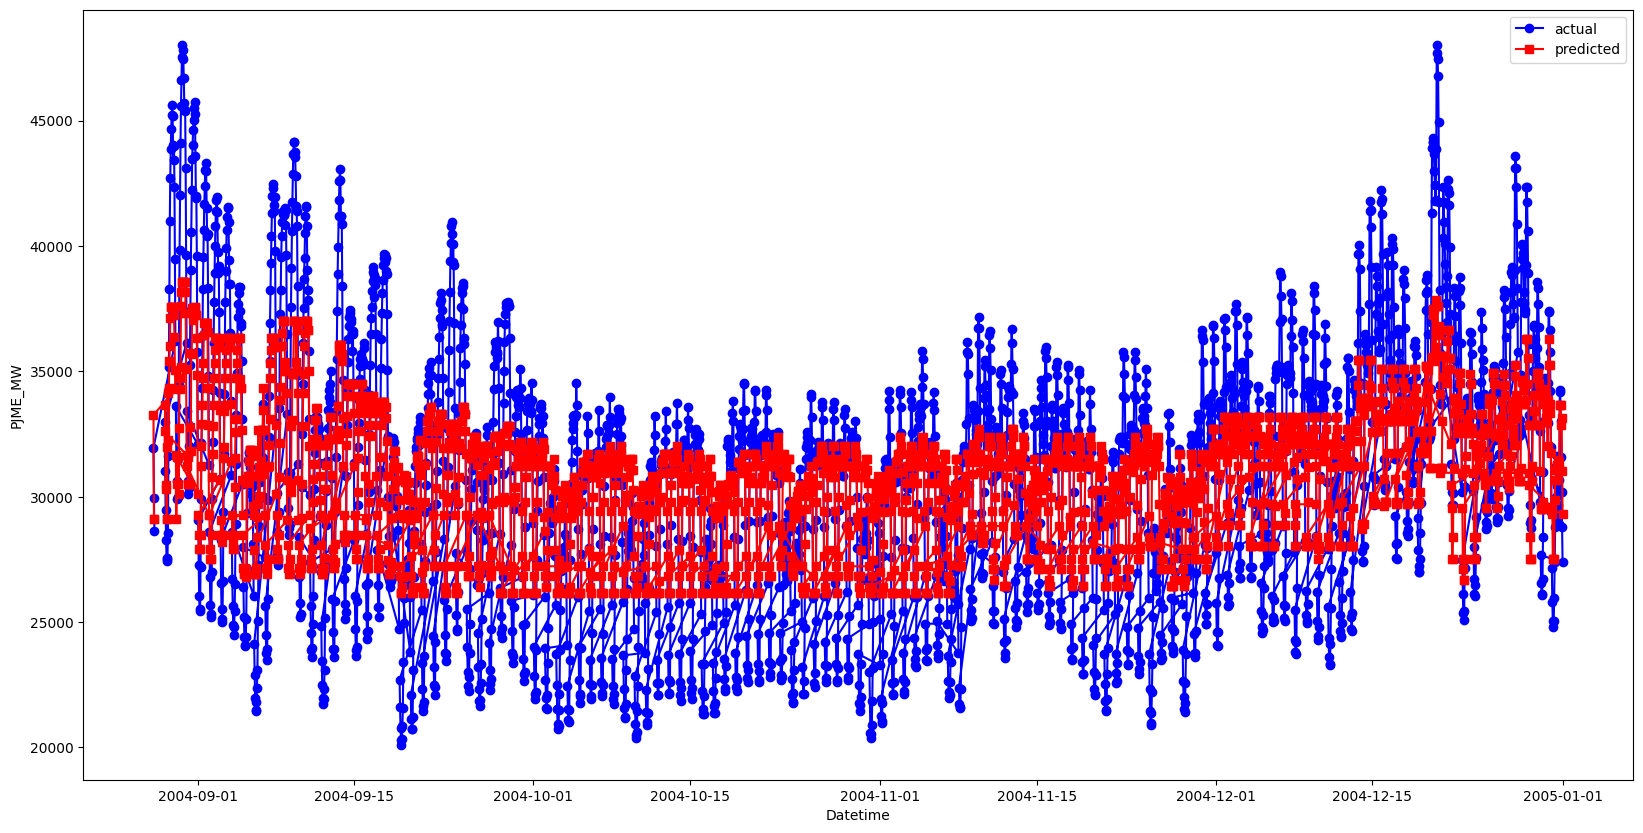

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(df['Datetime'], Actual_Values, label='actual',color='blue', marker='o')

plt.plot(df['Datetime'], Predicted_Values, label='predicted',color='red', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.legend()
plt.show()

Library Method

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import pickle

In [22]:
with open('dataframe.pickle', 'rb') as f:
    df = pickle.load(f)

In [23]:
# df=df[df.isna().sum(axis=1)==0]    #dropping null data frames

# mean=df.mean()
# std=df.std()
# df=(df-mean)/std  # Normalization

df=df[:3000]
df=df.drop(columns=['Datetime'])

X=df.drop(columns = ['PJME_MW'])
y=df['PJME_MW']

In [24]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=5, learning_rate=0.2, max_depth=5, random_state=42)

# Train the model
gb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Squared Error:", (mse)**0.5)

Mean Squared Error: 8184976.009304971
Mean Squared Error: 2860.9397073872374
